<h1 style='text-align : center ;'><u><b>IMAGE SIMILARITY<b></u></h1>

In [48]:
import os
import random
import time
import math

# import PIL
from PIL import Image
import cv2
import glob

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

<h2>InceptionNet (GoogLeNet)</h2>

In [49]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

    # concatenate filters
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

    return layer_out

<h2>ResNet(Residual Network)</h2>

In [50]:
def identity_block(x, filter):
    F1,F2,F3 = filter

    # Copy tensor to variable called x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(F1, (1,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(F2 , (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Layer 3
    x = tf.keras.layers.Conv2D(F3, (1,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Add Resdiue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [51]:
def convolutional_block(x , s, filter):
    F1,F2,F3 = filter

    # copy tensor to varible called x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(F1 , (1,1), padding='valid', strides=(s,s))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(F2, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 3
    x = tf.keras.layers.Conv2D(F3, (1,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Preprocessing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(F3, (1,1), padding='valid', strides=(s,s))(x_skip)
    x_skip = tf.keras.BatchNormalization(axis=3)(x_skip)

    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x


In [52]:
def ResNet_50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

    #stage 1
    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    #stage 2
    X = convolutional_block(X, s=1, filters=[64, 64, 256])
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256])

    #stage 3
    X = convolutional_block(X, s=2, filters=[128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])

    #stage 4
    X = convolutional_block(X, s=2, filters=[256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])

    #stage 5
    X = convolutional_block(X, s=2, filters=[512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])


    X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


<hr>

<h2>Loading the Pre-Trained Model </h2>

In [53]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')

In [54]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Loading the dataset

In [55]:
!gdown 1ewB9Pa1JW3ugRxe8GtsKC4oq5fkBRM4n

Downloading...
From (original): https://drive.google.com/uc?id=1ewB9Pa1JW3ugRxe8GtsKC4oq5fkBRM4n
From (redirected): https://drive.google.com/uc?id=1ewB9Pa1JW3ugRxe8GtsKC4oq5fkBRM4n&confirm=t&uuid=baebe602-0d2b-4c98-b732-f0915f787832
To: /content/Objects.zip
100% 79.6M/79.6M [00:01<00:00, 39.8MB/s]


In [56]:
# !unzip Objects.zip

In [57]:
object_folder_path = '/content/Objects'

In [58]:
# Get a list of all images from subfolders
image_paths = glob.glob(os.path.join(object_folder_path, "**", "*.jpg"), recursive=True)

In [59]:
print(f'Total images found : {len(image_paths)}')
print(image_paths[:5])

Total images found : 5887
['/content/Objects/kangaroo/image_0064.jpg', '/content/Objects/kangaroo/image_0051.jpg', '/content/Objects/kangaroo/image_0062.jpg', '/content/Objects/kangaroo/image_0013.jpg', '/content/Objects/kangaroo/image_0075.jpg']


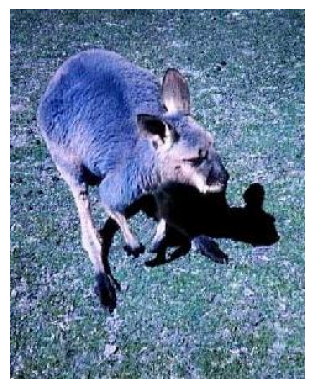

In [60]:
# Load and display the first image:
img = cv2.imread(image_paths[0])
plt.imshow(img)
plt.axis('off')
plt.show()

## Feature Extraction:-


In [61]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)     # Defines the expected input dimensions for the model
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))    # Resizing the image

    img_array = image.img_to_array(img)                          # Converting the image into a NumPy array of shape (224, 224, 3)
    expanded_img_array = np.expand_dims(img_array, axis=0)       # Adds an extra dimension to match the expected batch format for deep learning models
    preprocessed_img = preprocess_input(expanded_img_array)      # Applies model-specific preprocessing to prepare the image for the pre-trained model.

    features = model.predict(preprocessed_img)

    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)

    return normalized_features


In [62]:
!gdown 1TeotSFkduqk3ria8w1DGhbZ91zLRHkHK

Downloading...
From: https://drive.google.com/uc?id=1TeotSFkduqk3ria8w1DGhbZ91zLRHkHK
To: /content/airplane.jpg
100% 26.1k/26.1k [00:00<00:00, 10.4MB/s]


In [63]:
IMG_PATH = '/content/airplane.jpg'

In [64]:
features = extract_features(IMG_PATH, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [65]:
print('Total length of features for one image:', len(features))

Total length of features for one image: 2048


In [66]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list


#### Now lets run the extraction over the entire dataset and time it.

In [67]:
# path to your dataset
root_dir = 'Objects'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

5887


In [68]:
BATCH_SIZE = 128
generator = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                        shuffle=False,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=(224,224))

num_images = len(generator.file_paths)
num_epochs = int(math.ceil(num_images / BATCH_SIZE))

start_time = time.time()
feature_list = []
feature_list = model.predict(generator, num_epochs)
end_time = time.time()


Found 5887 files belonging to 60 classes.
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step


In [69]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(len(feature_list), -1)

print('Num images = ', len(generator.file_paths))
print('Shape of feature_list = ', feature_list.shape)
print('Time taken to extract features = ', end_time - start_time, 'seconds')

Num images =  5887
Shape of feature_list =  (5887, 2048)
Time taken to extract features =  20.69033718109131 seconds


## Finding similar images using KNN:-

In [70]:
random_index = random.randint(0, num_images)

In [71]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

distances, indices = neighbors.kneighbors([feature_list[random_index]])

In [72]:
%timeit distances, indices = neighbors.kneighbors([feature_list[random_index]])

20.5 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


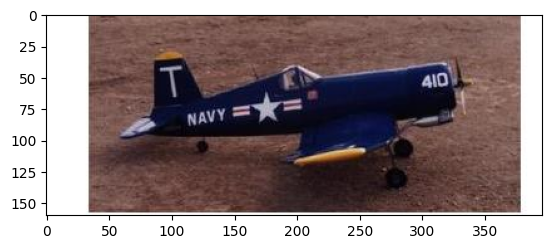

In [73]:
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filenames[random_index]))

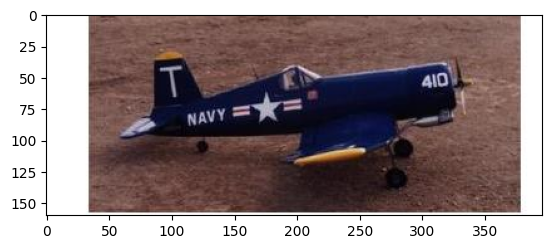

In [74]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

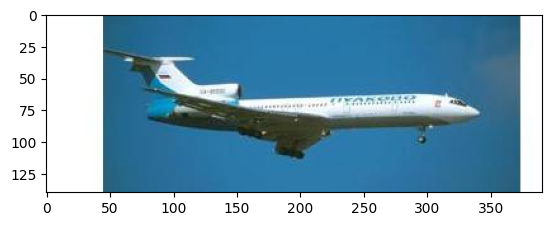

In [75]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

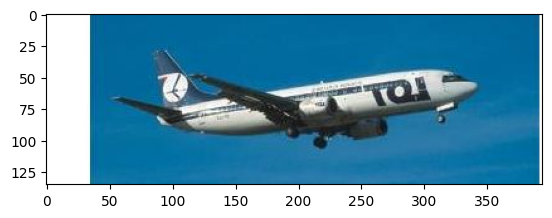

In [76]:
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

In [77]:
for i in range(5):
    print(distances[0][i])

0.0
0.7234336733818054
0.7398054003715515
0.7610671520233154
0.7611598968505859
